In [206]:
import yfinance as yf
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt

# Data Acquisition

In [203]:
# Define stock and interval historical data
SYMBOL = 'AAPL'
START_DATE = '2010-01-01'
END_DATE = '2018-06-29'

In [204]:
# Download historical data
def download_stock(symbol, start, end):
    data = yf.download(symbol, start=start_date, end=end_date)
    return data

raw = download_stock(symbol=SYMBOL, start=START_DATE, end=END_DATE)

[*********************100%%**********************]  1 of 1 completed


# Data Preparation: Forward Filling

Use the forward-filling technique to address gaps.

This method involves replacing missing values with the most recent available data, which is an effective strategy in maintaining continuity in the dataset.

In [196]:
# Show a sample of data
raw.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.478998,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.490202,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.386964,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.375156,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.417540,447610800


In [197]:
# Show data types
raw.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [200]:
def preprocess(raw):
    # Handle missing values
    data = raw.ffill()
    # Use only Closing price and Volume
    data = raw[['Close']]
    return data
    
data = preprocess(raw)
data.head()

,Close
Date,
2010-01-04,7.643214
2010-01-05,7.656429
2010-01-06,7.534643
2010-01-07,7.520714
2010-01-08,7.570714


# Data visualization

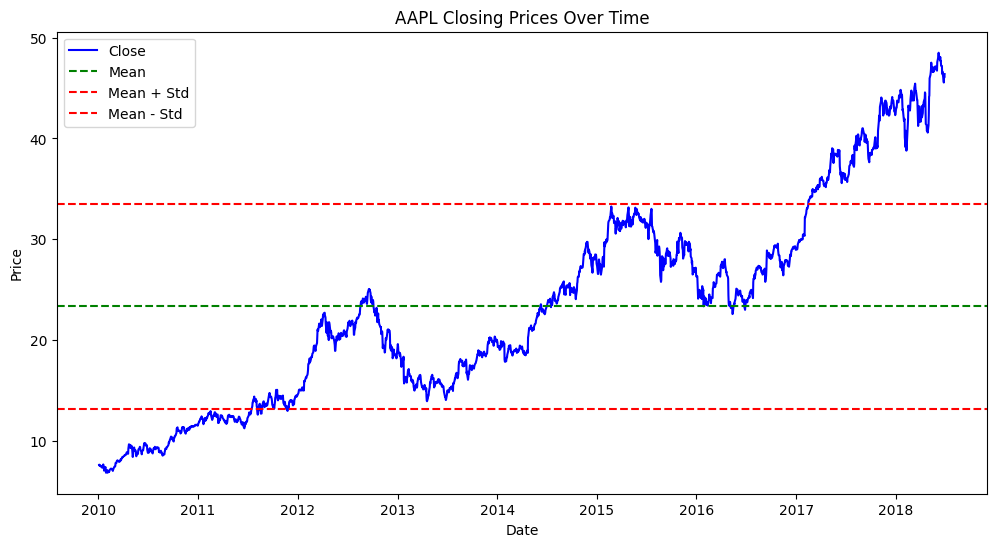

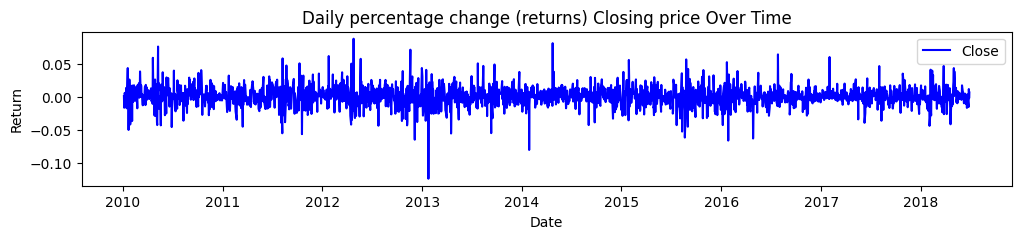

In [192]:
# Calculates key statistics
mean_close = data['Close'].mean()
std_close = data['Close'].std()

# Visualize the close price trend
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], color='blue', label='Close')
plt.title('AAPL Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Plot the mean and standard deviation as horizontal lines
plt.axhline(mean_close, color='green', linestyle='--', label='Mean')
plt.axhline(mean_close + std_close, color='red', linestyle='--', label='Mean + Std')
plt.axhline(mean_close - std_close, color='red', linestyle='--', label='Mean - Std')
plt.legend()

plt.show()

# Plot daily percentage change (returns) Closing price
plt.figure(figsize=(12, 2))
plt.plot(data.index, data['Close'] / data['Close'].shift() - 1, color='blue', label='Close')
plt.title('Daily percentage change (returns) Closing price Over Time')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.show()

# Strategy Development: Moving Average Crossover

In [158]:
def moving_average_crossover_strategy(data, sma1=42, sma2=252):
    # Compute Short-Term Average
    data['SMA1'] = data['Close'].rolling(window=sma1).mean()
    # Compute Long-Term Average
    data['SMA2'] = data['Close'].rolling(window=sma2).mean()
    # Identify buy and sell signals
    data['Position'] = 0
    data['Position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)
    # Drop rows where the strategy cannot be applied (ie: all rows where the windows are too small)
    data.dropna(inplace=True)
    return data

In [170]:
# Compute positions using our strategy
data = moving_average_crossover_strategy(data, sma1=42, sma2=252)
data.round(4).head()

,Close,Volume,SMA1,SMA2,Position,Returns
Date,,,,,,
2011-12-29,14.4686,215978000,13.8881,12.9885,1,0.0061
2011-12-30,14.4643,179662000,13.8883,13.0002,1,-0.0003
2012-01-03,14.6868,302220800,13.9008,13.0117,1,0.0153
2012-01-04,14.7657,260022000,13.9145,13.0234,1,0.0054
2012-01-05,14.9296,271269600,13.9272,13.0353,1,0.0110


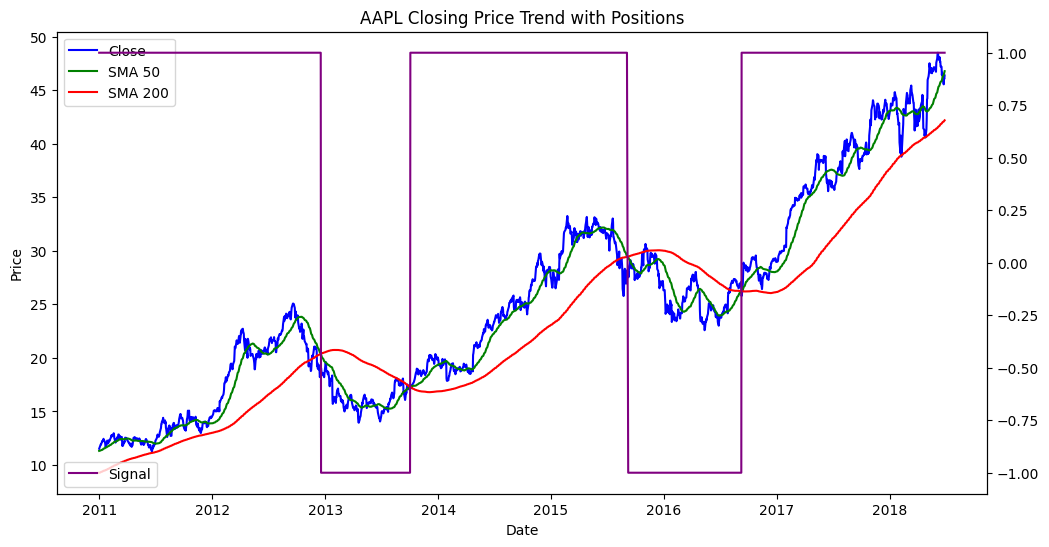

In [160]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Visualize the close price trend
ax1.plot(data.index, data['Close'], color='blue', label='Close')
plt.title('AAPL Closing Price Trend with Positions')
plt.xlabel('Date')
plt.ylabel('Price')
# ax1.legend()

# Plot SMA lines on the primary y-axis (ax1)
ax1.plot(data.index, data['SMA1'], color='green', label='SMA 50')
ax1.plot(data.index, data['SMA2'], color='red', label='SMA 200')

# Create a secondary y-axis (ax2) for the 'Signal' data
ax2 = ax1.twinx()

# Plot the 'Signal' data on the secondary y-axis with a dashed red line
ax2.plot(data.index, data['Position'], '-', color='purple', label='Signal')

# Set the y-axis limits for 'Signal' between -1 and 1
# ax2.set_ylim([-1.5, 1])

# Display the legend for both axes
ax1.legend()
ax2.legend()

plt.show()

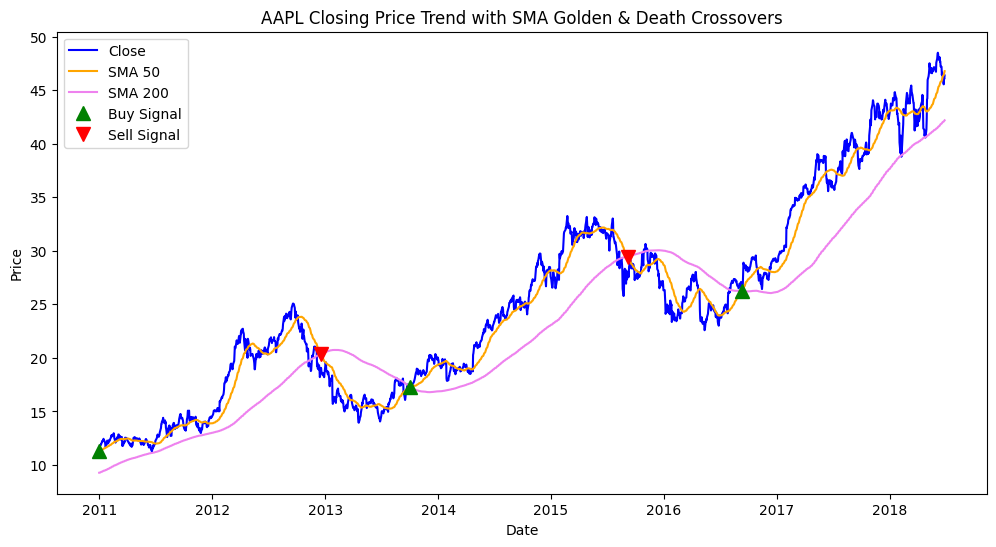

In [161]:
# Visualize the close price trend
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], color='blue', label='Close')
plt.title('AAPL Closing Price Trend with SMA Golden & Death Crossovers')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Plot SMA 50 days and SMA 200 days
plt.plot(data.index, data['SMA1'], color='orange', label='SMA 50')
plt.plot(data.index, data['SMA2'], color='violet', label='SMA 200')

# Highlights BUY signals
buy_signals = data[(data['Position'] != data['Position'].shift()) & (data['Position'] == 1)]
plt.plot(buy_signals.index, buy_signals['SMA1'], '^', markersize=10, color='green', label='Buy Signal')

# Highlights SELL signals
sell_signals = data[(data['Position'] != data['Position'].shift()) & (data['Position'] == -1)]
plt.plot(sell_signals.index, sell_signals['SMA2'], 'v', markersize=10, color='red', label='Sell Signal')

plt.legend()
plt.show()

# Backtesting the Strategy

In [162]:
def backtest_moving_average_crossover_strategy(data):
    # Compute log returns (ie: continuous return)
    data['Returns'] = np.log(data['Close'] / data['Close'].shift(1))

    # Benchmark investment: passively holding stock
    benchmark_returns = np.exp(data['Returns'].sum())
    
    # Strategy investment: BUY during golden crossover. SELL during death crossover
    strategy_returns = data['Position'].shift() * data['Returns']
    strategy_returns = np.exp(strategy_returns.sum())
    
    return benchmark_returns, strategy_returns

In [166]:
# Run backtesting
benchmark_returns, strategy_returns = backtest_moving_average_crossover_strategy(data)
print(f"Benchmark returns:", benchmark_returns)
print(f"Strategy returns:", strategy_returns)

Benchmark returns: 4.025607478925623
Strategy returns: 5.823537352236951


# Parameters Optimization

In [222]:
def optimize(historical_data, sma1=range(20, 61, 4), sma2=range(180, 281, 10)):
    # Grid search step
    results = pd.DataFrame()
    
    # Iterate over all combinations of SMA1 and SMA2 using the product function
    for SMA1, SMA2 in product(sma1, sma2):
        # Copy data to avoid modifying the original historical data
        data = pd.DataFrame(historical_data)
        
        # Capture signals using the Moving Average Crossover strategy
        data = moving_average_crossover_strategy(data, SMA1, SMA2)
        
        # Backtest the strategy
        perf_benchmark, perf_strategy = backtest_moving_average_crossover_strategy(data)
        
        # Save backtest results in a DataFrame
        result = pd.DataFrame({
            'SMA1': SMA1,
            'SMA2': SMA2,
            'MARKET': perf_benchmark,
            'STRATEGY': perf_strategy,
            'OUT': perf_strategy - perf_benchmark
        }, index=[0])
        
        # Concatenate the result with the previous results DataFrame
        results = pd.concat([results, result], ignore_index=True)

    # Sort the results DataFrame based on the performance difference (OUT) in descending order
    # This step helps identify the parameter combination that resulted in the highest strategy outperformance
    results = results.sort_values('OUT', ascending=False)

    # Return the sorted results DataFrame
    return results

In [224]:
historical_data = preprocess(raw)

optimize(historical_data).head(7)

,SMA1,SMA2,MARKET,STRATEGY,OUT
56,40,190,4.660135,7.190164,2.530029
39,32,240,4.054138,6.572394,2.518256
59,40,220,4.229091,6.557832,2.328741
46,36,200,4.083333,6.402977,2.319644
55,40,180,4.584613,6.872318,2.287705
70,44,220,4.229091,6.483342,2.254251
101,56,200,4.083333,6.332832,2.249499
